In [36]:
import torch
from torch import nn
from d2l import torch as d2l

In [37]:
# 实现注意力的可视化
# 输入matrices的形状是（要显示的行数，要显示的列数，查询的数目，键的数目）
# 每个矩阵（查询数目 × 键数目）对应一个子图。

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """显示矩阵热图"""
    # 使用 Matplotlib 的 rcParams 来设置 SVG 格式
    plt.rcParams['figure.dpi'] = 120  # 调整分辨率
    plt.rcParams['savefig.format'] = 'svg'  # 设置保存格式为 SVG

    # 获取矩阵的行列数
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]

    # 绘图相关参数讲解
    # num_rows, num_cols 子图网格的行列数
    # figsize 整个图像的宽度和高度
    # sharex=True, sharey=True 所有子图共享相同的x轴刻度
    # squeeze=False 无论子图网格的形状如何，axes 始终是一个二维数组。
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    # axes 的形状：(num_rows, num_cols)

    # 遍历每一行的子图和对应的矩阵
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        # 遍历每一列的子图和对应的矩阵
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])

    # 添加颜色条
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    plt.show()

In [38]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

In [44]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)

50

In [40]:
import matplotlib.pyplot as plt

def plot_kernel_reg(test_inputs, true_values, predicted_values, train_inputs, train_targets):
    """
    绘制训练样本、真实函数和预测函数。

    参数:
    - test_inputs: 测试输入数据
    - true_values: 测试数据对应的真实值/函数值
    - predicted_values: 测试数据对应的预测值
    - train_inputs: 训练输入数据
    - train_targets: 训练输出目标值
    """
    plt.figure(figsize=(8, 6))

    # 绘制真实函数和预测函数
    plt.plot(test_inputs, true_values, label='Ground Truth', color='blue', linestyle='-', linewidth=2)
    plt.plot(test_inputs, predicted_values, label='Predictions', color='orange', linestyle='--', linewidth=2)

    # 绘制训练数据点
    plt.scatter(train_inputs, train_targets, label='Training Data', color='red', alpha=0.5, marker='o')

    # 设置图例、标题和坐标轴标签
    plt.legend(loc='upper right', fontsize=12)
    plt.title('Kernel Regression Visualization', fontsize=14)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)

    # 设置坐标轴范围
    plt.xlim(0, 5)
    plt.ylim(-1, 5)

    # 显示绘图
    plt.grid(alpha=0.3)
    plt.show()

## 平均汇聚

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$

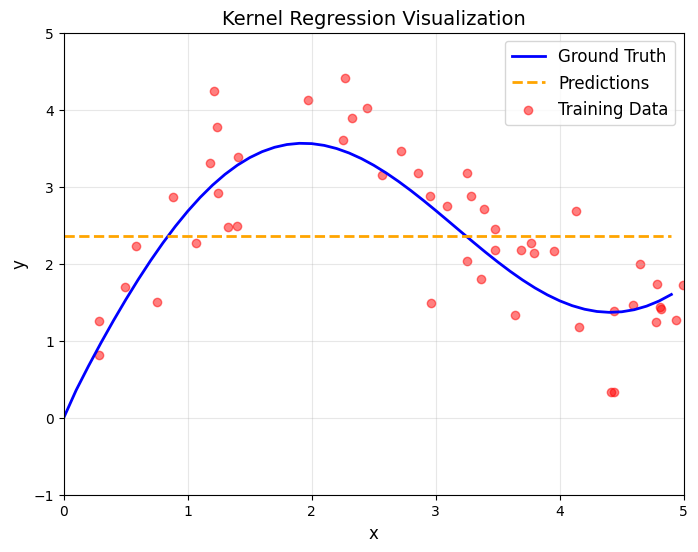

In [41]:
# 将 y_train.mean() 的值重复多次，形成一个与测试样本数量 n_test 相同的张量。
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
# 调用绘图函数
plot_kernel_reg(
    test_inputs=x_test,
    true_values=y_truth,
    predicted_values=y_hat,
    train_inputs=x_train,
    train_targets=y_train
)

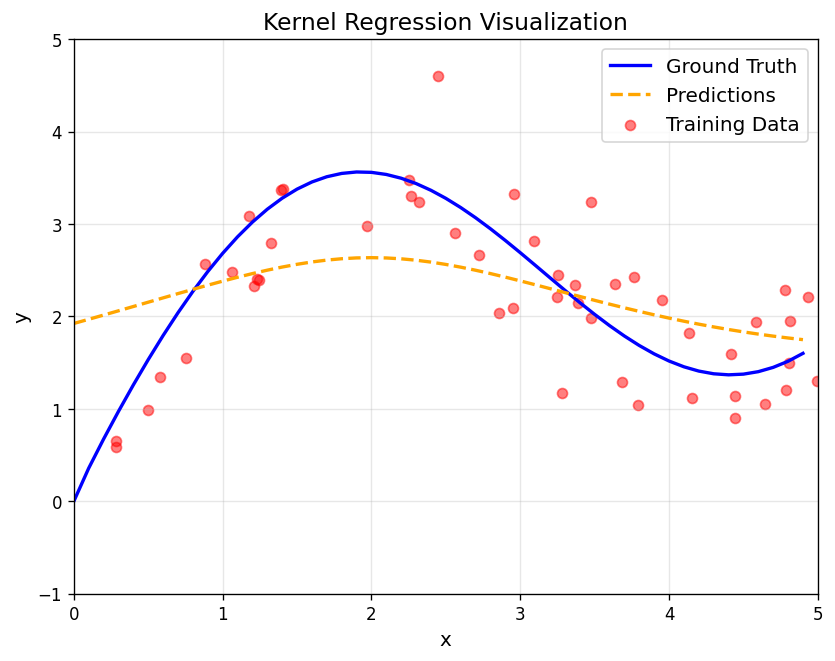

In [52]:
# 不带参数的注意力汇聚

# x_test: 测试输入张量，形状为 (n_test,)
# n_train: 训练样本的数量      n_test==n_train
# repeat_interleave(n_train)：对 x_test 中的每个元素重复 n_train 次，形成长度为 n_test * n_train 的一维张量。
# .reshape((-1, n_train))：将其重塑为形状 (n_test, n_train) 的二维张量。
# X_repeat的形状:(n_test,n_train),
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))

# x_train 的形状是 (n_train,)
# 广播机制 x_train 的形状扩展为 (n_test, n_train)
# (X_repeat - x_train)**2：计算每个测试样本与每个训练样本之间的平方距离。
# - (...) / 2：将距离值取负并除以 2，模拟高斯核函数的形式。
# nn.functional.softmax(..., dim=1)：对每行应用 Softmax 函数，将距离转化为概率分布（注意力权重），和为 1。
# attention_weights 的形状为 (n_test, n_train)
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)

# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
# y_train 的形状是 (n_train,)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(
    test_inputs=x_test,
    true_values=y_truth,
    predicted_values=y_hat,
    train_inputs=x_train,
    train_targets=y_train
)

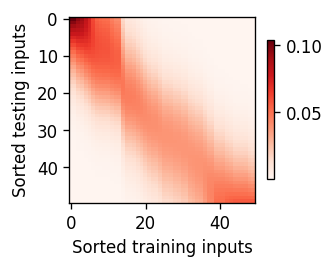

In [53]:
# 测试数据的输入相当于查询 训练数据的输入相当于键
# 查询和键的距离越接近 对应的注意力权重就越高

show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [55]:
# 批量矩阵乘法示例
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [57]:
# 使用小批量矩阵乘法来计算小批量数据中的加权平均值
# weights形状：(2, 10)，表示有2个批次（batch），每个批次有10个权重。
weights = torch.ones((2, 10)) * 0.1
# values：(2, 10)，表示有2个批次（batch），每个批次有10个值。
values = torch.arange(20.0).reshape((2, 10))
# unsqueeze(1) 在1维后面增加一个维度 weights(2, 10)->(2,1,10)
# unsqueeze(-1) 在最后一维增加一个维度 values(2, 10)->(2,10,1)。
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))
# 最后结果(2,1,1)

tensor([[[ 4.5000]],

        [[14.5000]]])

In [10]:
# 使用小批量矩阵乘法 基于带参数的注意力汇聚 定义核回归带参数模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

### 训练

接下来，[**将训练数据集变换为键和值**]用于训练注意力模型。
在带参数的注意力汇聚模型中，
任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算，
从而得到其对应的预测输出。


In [11]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

[**训练带参数的注意力汇聚模型**]时，使用平方损失函数和随机梯度下降。


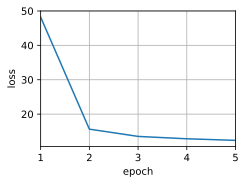

In [12]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

如下所示，训练完带参数的注意力汇聚模型后可以发现：
在尝试拟合带噪声的训练数据时，
[**预测结果绘制**]的线不如之前非参数模型的平滑。


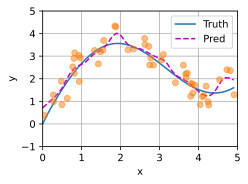

In [13]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

为什么新的模型更不平滑了呢？
下面看一下输出结果的绘制图：
与非参数的注意力汇聚模型相比，
带参数的模型加入可学习的参数后，
[**曲线在注意力权重较大的区域变得更不平滑**]。


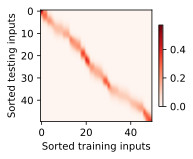

In [14]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')